In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import files
import math

# ------- 1) 데이터 업로드 -------
uploaded = files.upload()
INPUT_PATH = next(fn for fn in uploaded if fn.endswith(('.xlsx', '.xls')))
df = pd.read_excel(INPUT_PATH)

Saving 202501_clean2.xlsx to 202501_clean2 (1).xlsx


In [15]:
# ---------- 2) 대상 금속 컬럼 ----------
TARGET_METALS = ['Cr(ng/m3)', 'Co(ng/m3)', 'Ni(ng/m3)',
                 'As(ng/m3)', 'Cd(ng/m3)', 'Sb(ng/m3)', 'Pb(ng/m3)']

# ---------- 3) 후보 분포(지시 목록 14종) ----------
DIST_MAP = {
    "정규":         stats.norm,
    "스튜던트의 t":  stats.t,
    "삼각형":        stats.triang,
    "로지스틱":      stats.logistic,
    "베타":         stats.beta,
    "최대 극값":     stats.gumbel_r,
    "최소 극값":     stats.gumbel_l,
    "와이블":       stats.weibull_min,
    "감마":         stats.gamma,
    "로그 정규":     stats.lognorm,
    "지수":         stats.expon,
    "균일":         stats.uniform,
    "파레토":       stats.pareto,
}
DIST_LIST_KR = list(DIST_MAP.keys()) + ["BetaPERT"]  # BetaPERT는 별도 처리

In [16]:
# ---------- 4) BetaPERT 유틸 ----------
def betapert_alpha_beta(a, m, b, lamb=4.0):
    if not (a < m < b): return None, None
    alpha = 1.0 + lamb * (m - a) / (b - a)
    beta  = 1.0 + lamb * (b - m) / (b - a)
    if alpha <= 0 or beta <= 0: return None, None
    return alpha, beta

def fit_betapert(x, lamb=4.0):
    a = float(np.min(x)); b = float(np.max(x))
    hist, edges = np.histogram(x, bins='auto')
    if len(hist)==0 or np.sum(hist)==0 or a==b: return None
    idx = int(np.argmax(hist)); m = float(0.5*(edges[idx]+edges[idx+1]))
    alpha, beta = betapert_alpha_beta(a, m, b, lamb=lamb)
    if alpha is None: return None
    return (alpha, beta, a, (b - a))

# ---------- 5) 지지 영역 처리 ----------
def select_data_for_dist(x: np.ndarray, dist_name_kr: str) -> np.ndarray:
    pos_only = dist_name_kr in ("베타","와이블","감마","로그 정규","지수","파레토","BetaPERT")
    x = x[~np.isnan(x)]
    return x[x > 0] if pos_only else x

In [17]:
# ---------- 6) 적합도 지표 계산 함수 ----------
def anderson_darling_stat_generic(dist, params, x: np.ndarray):
    x = np.sort(x); n = x.size
    if n < 5: return np.nan, np.nan
    F = np.clip(dist.cdf(x, *params), 1e-12, 1-1e-12)
    i = np.arange(1, n+1)
    A2 = -n - np.mean((2*i - 1)*(np.log(F)+np.log(1-F[::-1])))
    return float(A2), np.nan  # p-값은 '---'

def ks_test(dist, params, x: np.ndarray):
    try: D, p = stats.kstest(x, dist.cdf, args=params); return float(D), float(p)
    except: return np.nan, np.nan

def chisq_gof(dist, params, x: np.ndarray, min_expected=5, bins_min=5, bins_max=20):
    n = x.size
    if n < 10: return np.nan, np.nan
    bins0 = int(np.clip(int(np.sqrt(n)), bins_min, bins_max))
    hist, edges = np.histogram(x, bins=bins0)
    cdfs = dist.cdf(edges, *params)
    expected = n * np.diff(cdfs)

    counts = hist.astype(float).tolist()
    expct  = expected.astype(float).tolist()
    edges_list = edges.tolist()

    i = 0
    while i < len(expct):
        if expct[i] < min_expected:
            if i == 0:
                counts[1]+=counts[0]; expct[1]+=expct[0]
                edges_list.pop(1); counts.pop(0); expct.pop(0)
            elif i == len(expct)-1:
                counts[i-1]+=counts[i]; expct[i-1]+=expct[i]
                edges_list.pop(i); counts.pop(i); expct.pop(i); i-=1
            else:
                if expct[i-1] < expct[i+1]:
                    counts[i-1]+=counts[i]; expct[i-1]+=expct[i]
                    edges_list.pop(i); counts.pop(i); expct.pop(i); i-=1
                else:
                    counts[i+1]+=counts[i]; expct[i+1]+=expct[i]
                    edges_list.pop(i+1); counts.pop(i); expct.pop(i)
        else:
            i+=1

    if len(expct)<2 or any(e<min_expected for e in expct): return np.nan, np.nan
    obs=np.array(counts); exp=np.array(expct)
    dof=max(len(exp)-1-len(params),1)
    chi_stat=np.sum((obs-exp)**2/(exp+1e-12))
    chi_p=1-stats.chi2.cdf(chi_stat,dof)
    return float(chi_stat), float(chi_p)

In [26]:
# ---------- 7) 분포 피팅 + 적합도 계산 ----------
def fit_one_dist(x: np.ndarray, dist_name_kr: str):
    x_use = select_data_for_dist(x, dist_name_kr)
    if x_use.size < 5:
        return {"분포": dist_name_kr,"A-D":np.nan,"A-D P-값":np.nan,
                "K-S":np.nan,"K-S P-값":np.nan,"카이제곱":np.nan,"카이제곱 P-값":np.nan,
                "params":None,"dist_obj":None,"x_use":x_use}
    try:
        if dist_name_kr=="BetaPERT":
            params=fit_betapert(x_use,4.0)
            if params is None: raise RuntimeError("BetaPERT 추정 실패")
            dist=stats.beta
        else:
            dist=DIST_MAP[dist_name_kr]
            if dist_name_kr in ("와이블","감마","지수","파레토","로그 정규"):
                try: params=dist.fit(x_use,floc=0)
                except: params=dist.fit(x_use)
            else: params=dist.fit(x_use)
    except: return {"분포":dist_name_kr,"A-D":np.nan,"A-D P-값":np.nan,
                   "K-S":np.nan,"K-S P-값":np.nan,"카이제곱":np.nan,"카이제곱 P-값":np.nan,
                   "params":None,"dist_obj":None,"x_use":x_use}
    A2,_=anderson_darling_stat_generic(dist,params,x_use)
    KS_D,KS_p=ks_test(dist,params,x_use)
    CHI,CHI_p=chisq_gof(dist,params,x_use)
    return {"분포":dist_name_kr,"A-D":A2,"A-D P-값":np.nan,
            "K-S":KS_D,"K-S P-값":KS_p,"카이제곱":CHI,"카이제곱 P-값":CHI_p,
            "params":params,"dist_obj":dist,"x_use":x_use}

    # 적합도 계산
    A2, _ = anderson_darling_stat_generic(dist, params, x_use)  # A-D p값은 --- 처리
    KS_D, KS_p = ks_test(dist, params, x_use)
    CHI, CHI_p = chisq_gof(dist, params, x_use)

    return {"분포": dist_name_kr, "A-D": A2, "A-D P-값": np.nan,  # 표시는 '---'
            "K-S": KS_D, "K-S P-값": KS_p,
            "카이제곱": CHI, "카이제곱 P-값": CHI_p,
            "params": params, "dist_obj": dist, "x_use": x_use, "err": None}

In [32]:
# ---------- 8) 자동 선정 규칙 ----------
_NAME_CANON = {"스튜던트 t": "스튜던트의 t", "Student t": "스튜던트의 t", "student_t": "스튜던트의 t"}
def _canon(name: str) -> str:
    return _NAME_CANON.get(str(name), str(name))

def choose_best(res_df: pd.DataFrame, alpha=0.05):
    """기본: KS/χ² 통과군 우선 → A-D 최소
       타이브레이커: (1) 정규 > 스튜던트의 t(특히 df↑)  (2) 지수 > 감마"""
    df = res_df.copy()
    for c in ["A-D","K-S P-값","카이제곱 P-값"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # 1) 우선 풀 선택
    passed = df[(df["K-S P-값"] >= alpha) & (df["카이제곱 P-값"] >= alpha)]
    pool = passed if not passed.empty else df

    # 2) A-D 최소 후보(근접치 포함)
    min_ad = pool["A-D"].min()
    # 상대 오차 허용 (데이터/분포에 따라 A-D 차이가 매우 작을 수 있음)
    tol = max(1e-6, 0.01 * float(min_ad) if pd.notna(min_ad) else 1e-6)
    cand = pool[pool["A-D"] <= (min_ad + tol)].copy()

    # 내부 헬퍼: cand/pool에서 이름으로 row 얻기
    def _get(name, src):
        name = _canon(name)
        hit = src[src["분포"].map(_canon) == name]
        return hit.iloc[0] if not hit.empty else None

    # --- 타이브레이커 #1: 정규 vs t (df가 매우 크면 사실상 정규) ---
    norm_row = _get("정규", cand)
    t_row    = _get("스튜던트의 t", cand)
    if norm_row is not None and t_row is not None:
        # 둘 다 A-D 근접이면 정규 우선
        best = norm_row
    else:
        # cand에는 하나만 있지만 pool에 둘 다 있고 A-D 거의 같으면 정규 우선
        norm_pool = _get("정규", pool)
        t_pool    = _get("스튜던트의 t", pool)
        if norm_pool is not None and t_pool is not None:
            try:
                # t의 df 확인 (params=(df, loc, scale))
                df_hat = float(t_pool["params"][0]) if isinstance(t_pool["params"], tuple) else None
            except Exception:
                df_hat = None
            ad_gap = abs(float(norm_pool["A-D"]) - float(t_pool["A-D"]))
            if ad_gap <= tol or (df_hat is not None and df_hat > 1e6):
                best = norm_pool
            else:
                best = cand.iloc[0]
        else:
            best = cand.iloc[0]

    # --- 타이브레이커 #2: 지수 vs 감마 (지수 우선) ---
    # 위에서 best가 정해졌더라도, 지수/감마가 근접 동점이면 지수로 스위치
    exp_row = _get("지수", pool)
    gam_row = _get("감마", pool)
    if exp_row is not None and gam_row is not None:
        ad_gap = abs(float(exp_row["A-D"]) - float(gam_row["A-D"]))
        # 지수와 감마가 A-D 근접(동점)인 상황 & 둘 다 현재 선택 후보군이면 지수로
        if (ad_gap <= tol) and (_canon(best["분포"]) in {"지수","감마"}):
            best = exp_row

    reason = "K-S/χ² 통과 + A-D 최소" if not passed.empty else "모두 미통과, A-D 최소"
    return best, reason

In [33]:
# 분포명 정규화(철자/띄어쓰기 차이 흡수)
NAME_CANON = {
    "스튜던트 t": "스튜던트의 t",
    "Student t": "스튜던트의 t",
    "student_t": "스튜던트의 t",
}
def canon(name: str) -> str:
    return NAME_CANON.get(name, name)

# 보기 좋은 라벨(한글/영문 병기)
DISPLAY_NAME = {
    "정규": "정규 / norm",
    "스튜던트의 t": "스튜던트 t / t",
    "삼각형": "삼각형 / triang",
    "로지스틱": "로지스틱 / logistic",
    "베타": "베타 / beta",
    "최대 극값": "최대 극값 / gumbel_r",
    "최소 극값": "최소 극값 / gumbel_l",
    "와이블": "와이블 / weibull_min",
    "감마": "감마 / gamma",
    "로그 정규": "로그 정규 / lognorm",
    "지수": "지수 / expon",
    "균일": "균일 / uniform",
    "파레토": "파레토 / pareto",
    "BetaPERT": "BetaPERT / beta"
}
def display_name(name: str) -> str:
    return DISPLAY_NAME.get(canon(name), name)

# 파라미터 표기
def fmt(v, d=3):
    try: return f"{float(v):.{d}g}"
    except: return str(v)

def describe_params_kr(name, params):
    name = canon(name)
    if params is None: return ""
    if name == "정규":
        loc, scale = params; return f"loc={fmt(loc)}, scale={fmt(scale)}"
    if name == "스튜던트의 t":
        df, loc, scale = params; return f"df={fmt(df)}, loc={fmt(loc)}, scale={fmt(scale)}"
    if name == "로지스틱":
        loc, scale = params; return f"loc={fmt(loc)}, scale={fmt(scale)}"
    if name in ("최대 극값","최소 극값"):
        loc, scale = params; return f"loc={fmt(loc)}, scale={fmt(scale)}"
    if name == "와이블":
        c, loc, scale = params; return f"c={fmt(c)}, loc={fmt(loc)}, scale={fmt(scale)}"
    if name == "감마":
        a, loc, scale = params; return f"a={fmt(a)}, loc={fmt(loc)}, scale={fmt(scale)}"
    if name == "로그 정규":
        s, loc, scale = params; return f"s={fmt(s)}, loc={fmt(loc)}, scale={fmt(scale)}"
    if name == "지수":
        loc, scale = params; return f"loc={fmt(loc)}, scale={fmt(scale)}"
    if name == "균일":
        loc, scale = params; return f"min={fmt(loc)}, max={fmt(loc+scale)}"
    if name == "파레토":
        b, loc, scale = params; return f"b={fmt(b)}, loc={fmt(loc)}, scale={fmt(scale)}"
    if name == "삼각형":
        c, loc, scale = params; mode = loc + c*scale
        return f"min={fmt(loc)}, mode={fmt(mode)}, max={fmt(loc+scale)}"
    if name == "베타":
        a, b, loc, scale = params; return f"a={fmt(a)}, b={fmt(b)}, min={fmt(loc)}, max={fmt(loc+scale)}"
    if name == "BetaPERT":
        a, b, loc, scale = params; return f"a={fmt(a)}, b={fmt(b)}, min={fmt(loc)}, max={fmt(loc+scale)}"
    return ", ".join(fmt(p) for p in params)

/tmp/ipython-input-2464776770.py:104: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2464776770.py:104: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2464776770.py:104: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2464776770.py:104: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2464776770.py:104: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2464776770.py:104: UserWarning: Glyph 53916 (\N{HANGUL SYLLABLE TYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2464776770.py:104: UserWarning: Glyph 45912 (\N{HANGUL SYLLABLE DEON}) missing from font(s) DejaVu Sans.
  plt.tight_

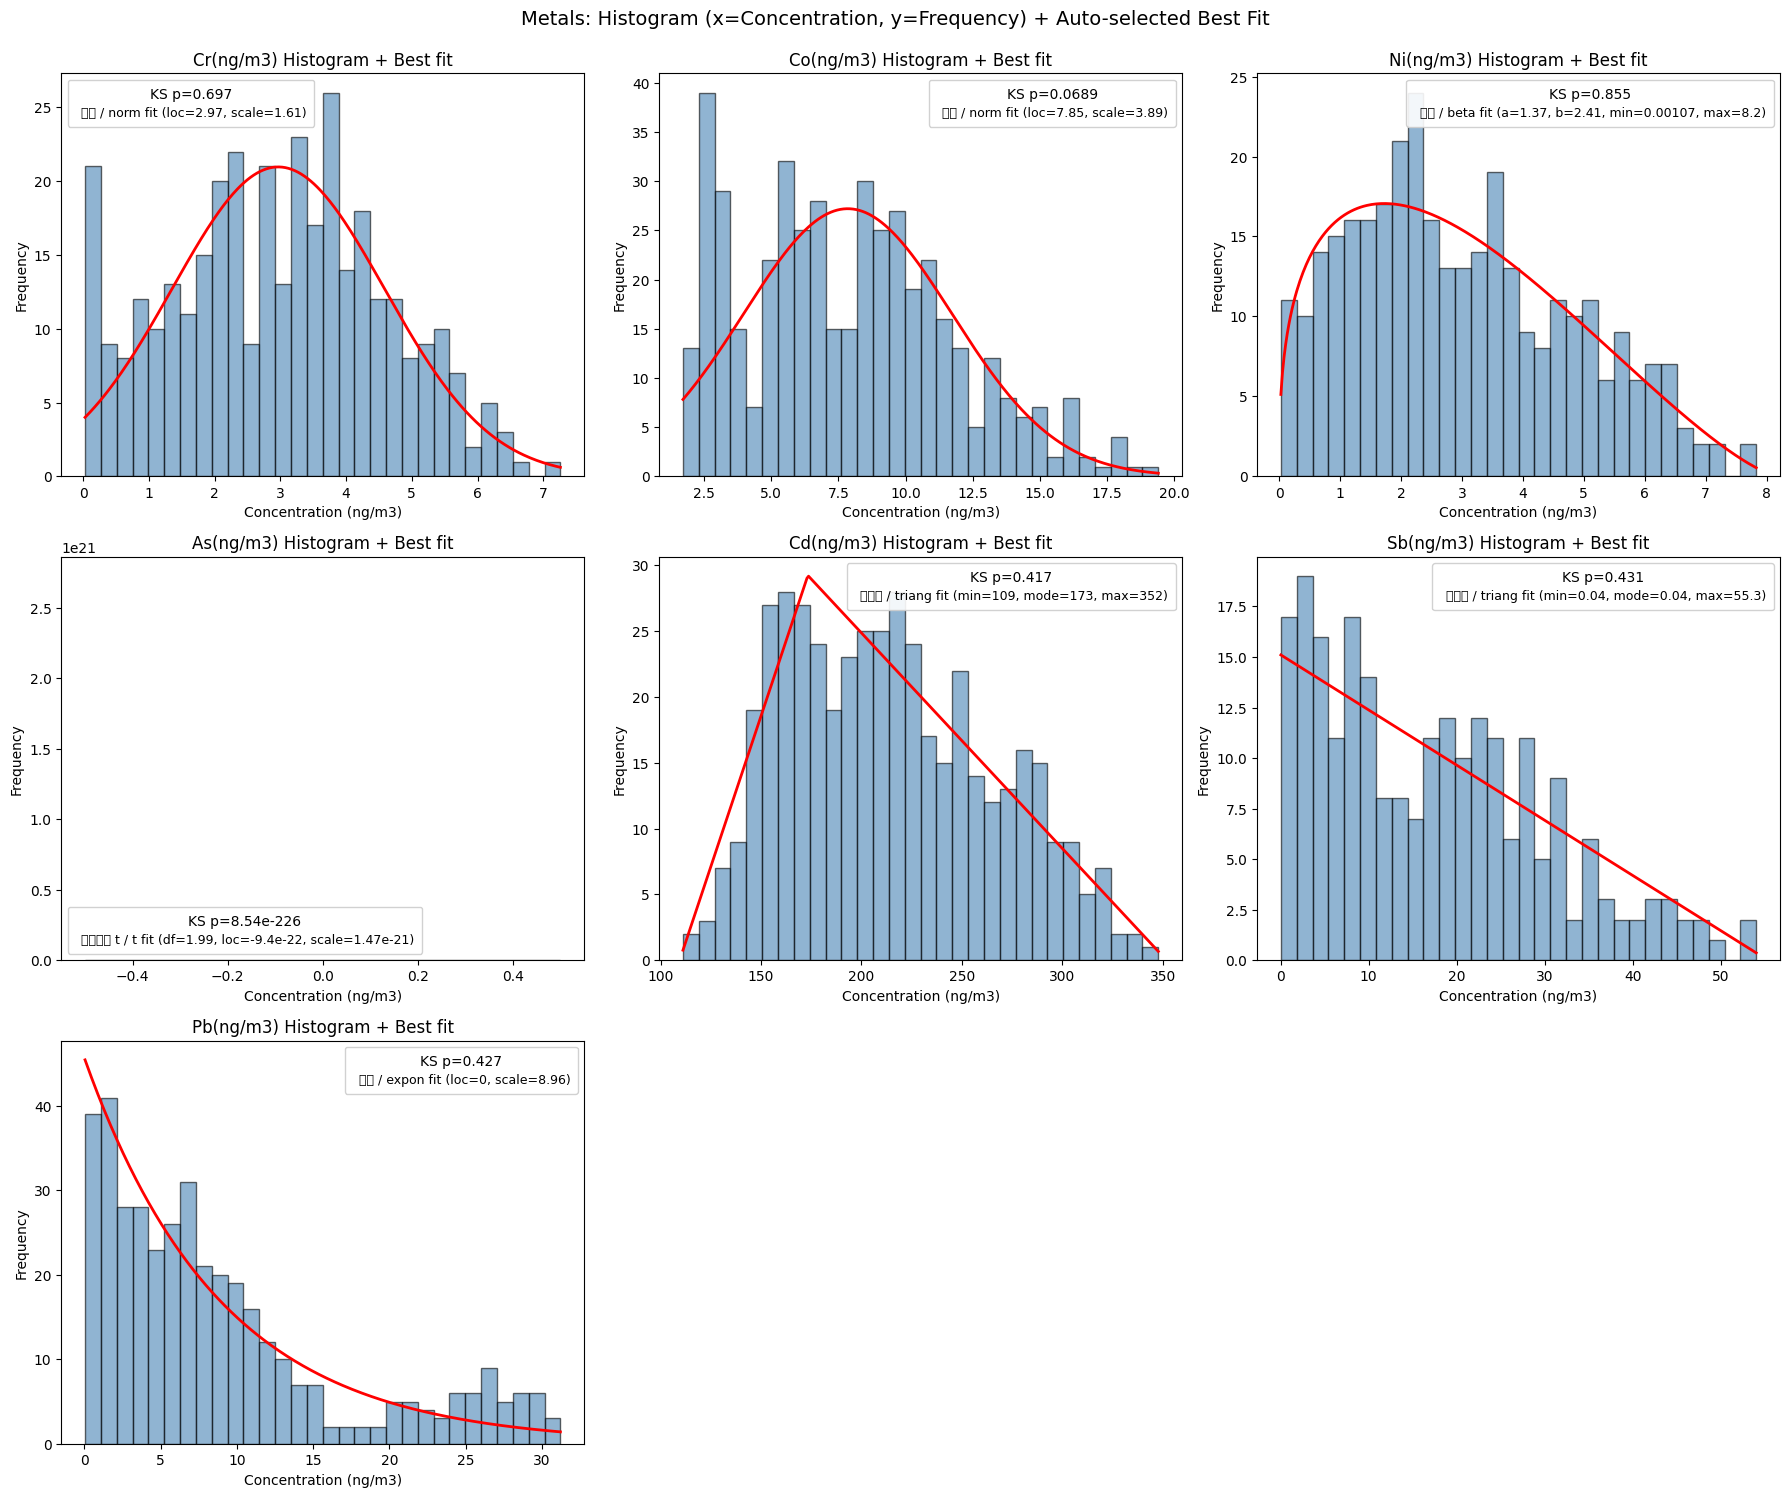

In [42]:
# ---------- 9) 금속별 계산 & 한 장에 격자 출력 ----------
n = len(TARGET_METALS); cols = 3; rows = math.ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5))
axes = np.array(axes).reshape(rows, cols)
summary_rows = []

for idx, metal in enumerate(TARGET_METALS):
    r, c = divmod(idx, cols)
    ax = axes[r, c]

    if metal not in df.columns:
        ax.axis('off')
        continue

    x = pd.to_numeric(df[metal], errors='coerce').dropna().to_numpy()
    if x.size < 5:
        ax.axis('off')
        continue

    # 분포별 적합도 평가
    recs, fit_cache = [], {}
    for name in DIST_LIST_KR:
        res = fit_one_dist(x, name); fit_cache[name] = res
        recs.append({k: res.get(k) for k in
                     ["분포","A-D","A-D P-값","K-S","K-S P-값","카이제곱","카이제곱 P-값","params"]})
    res_df = pd.DataFrame(recs)

    # 1차 자동 선정
    best, reason = choose_best(res_df)


    # --- Pb 전용 규칙 ---
    PB_FORCE_EXP = True
    if metal.startswith("Pb"):
        exp_row = res_df[res_df["분포"] == "지수"]
        gam_row = res_df[res_df["분포"] == "감마"]

        if 'PB_FORCE_EXP' in globals() and PB_FORCE_EXP:
            if not exp_row.empty:
                best = exp_row.iloc[0]
                reason += " + Pb rule(지수 강제)"
        else:
            if (not exp_row.empty) and (not gam_row.empty):
                Aexp = float(exp_row["A-D"].iloc[0]); Agam = float(gam_row["A-D"].iloc[0])
                if Aexp <= Agam * 1.05:  # 5% 이내면 지수 우선
                    best = exp_row.iloc[0]
                    reason += " + Pb rule(지수 우선)"

    # 최종 선택 반영
    best_name = best["분포"]
    best_res  = fit_cache[best_name]
    x_use     = best_res["x_use"]

    # 히스토그램 (y=빈도)
    counts, bins_hist, _ = ax.hist(
        x_use, bins=30, density=False,
        alpha=0.6, edgecolor="black", color="steelblue"
    )

    # 최적 분포 곡선(히스토그램 스케일)
    dist_obj = best_res["dist_obj"]; params = best_res["params"]
    if dist_obj is not None and params is not None and len(bins_hist) > 1:
        xgrid = np.linspace(np.min(x_use), np.max(x_use), 300)
        pdf = dist_obj.pdf(xgrid, *params)
        bin_width = (bins_hist[1] - bins_hist[0])

        # 보기 좋은 라벨(분포명+파라미터)
        best_name_c = canon(best_name)
        param_txt = describe_params_kr(best_name_c, params)
        line_label = f"{display_name(best_name_c)} fit ({param_txt})"

        ax.plot(xgrid, pdf * len(x_use) * bin_width,
                lw=2, color="red", label=line_label)

    # 축/제목/범례
    ax.set_title(f"{metal} Histogram + Best fit")
    ax.set_xlabel("Concentration (ng/m3)")
    ax.set_ylabel("Frequency")

    title_txt = f"KS p={best['K-S P-값']:.3g}" if pd.notna(best["K-S P-값"]) else "KS p=---"
    leg = ax.legend(
        title=title_txt, loc="best",
        frameon=True, fancybox=True, framealpha=0.9,
        fontsize=9, title_fontsize=10,
        handlelength=0,    # 범례에서 선 샘플 제거
        handletextpad=0.5, borderpad=0.6, labelspacing=0.4
    )

    # 요약 행
    summary_rows.append({
        "금속": metal, "선정 분포": best_name, "선정 사유": reason,
        "A-D": best["A-D"], "A-D P-값": '---',
        "K-S": best["K-S"], "K-S P-값": best["K-S P-값"],
        "카이제곱": best["카이제곱"], "카이제곱 P-값": best["카이제곱 P-값"]
    })

# 남는 축 비우기
for k in range(n, rows*cols):
    r, c = divmod(k, cols)
    axes[r, c].axis('off')

fig.suptitle("Metals: Histogram (x=Concentration, y=Frequency) + Auto-selected Best Fit",
             y=0.995, fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ---------- 10) 요약 저장 ----------
summary_df = pd.DataFrame(summary_rows)
summary_df.to_excel("AutoFit_Summary.xlsx", index=False)
print("[완료] 요약 저장: AutoFit_Summary.xlsx")